<a href="https://colab.research.google.com/github/gmoneymiller/hello-world/blob/master/Honey_Bee_Health_Classifier_98_75_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is Honey Bee Health Classifier.  This code builds, trains and then evaluates a neural network to classify bees in distress. It achieved an initial 98.75% test accuracy, i.e. with no hyperparameter search.  With a little work we can probably push it beyond 99%.

The dataset for this project consists of 5,100+ photos of bees, labeled by professional beekeepers according to the category of distress each bee is in.

The model is based on a homework problem I submitted for an applied AI class at NCSU. Because the source data is staged differently than for that homework,  this code first has to rearrange the input files into train/test/validate categorical subfolders, so that the data can be augmented by ImageDataGenerator and fed into the network via flow_from_directory.

The model is basically a partially-trainable knowledge transfer (KT) using VGG16, with a single, 512-node relu layer between the convolutional KT and the final softmax layers.  

Also the source data was cleaned in two ways: 1) two similar health categories ("varrao") were collapsed into one category; 2) a rare category ("missing queen") was eliminated.  See "Prep the data" below.

## Dataset

The credit for collecting and preparing the honeybee dataset goes to Jenny Yang from Kaggle: https://www.kaggle.com/jenny18/honey-bee-annotated-images/.


In [4]:
!rm -rf bee_imgs.zip bee_data.csv bee_imgs __MACOSX
!unzip -qa honey-bee-annotated-images.zip
!unzip -qa bee_imgs.zip
!ls -ltrdh *

drwxr-xr-x 2 root root 136K Sep 16 23:39 bee_imgs
drwxrwxr-x 3 root root 4.0K Sep 16 23:39 __MACOSX
---------- 1 root root  51M Sep 16 23:42 bee_imgs.zip
---------- 1 root root 486K Sep 16 23:42 bee_data.csv
drwxr-xr-x 1 root root 4.0K Jan 29 17:09 sample_data
-rw-r--r-- 1 root root  51M Jan 31 16:54 honey-bee-annotated-images.zip


In [0]:
import numpy as np
import pandas as pd
import random, datetime, os, shutil, math
import matplotlib.pyplot as plt
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16
from keras import layers
from keras import models
from keras import optimizers
from google.colab import files 

image_size = (150, 150)
#images in:
base_dir = '/content/bee_imgs'
#will be rearranged into:
input_dir = '/content/bees'

def logprint(msg):
  print("["+str(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))+"] "+str(msg))

#display a sample of bee photos:
def show_bees(bzz):
  rows = int(math.sqrt(len(bzz)))
  cols = (len(bzz)+1)//rows
  f, axs = plt.subplots(rows, cols)
  fig = 0
  for b in bzz:
    img_path = os.path.join(base_dir, b)
    img = image.load_img(img_path)
    row = fig // cols
    col = fig % cols
    axs[row, col].imshow(img)
    fig += 1
  plt.show()

#Sample Images

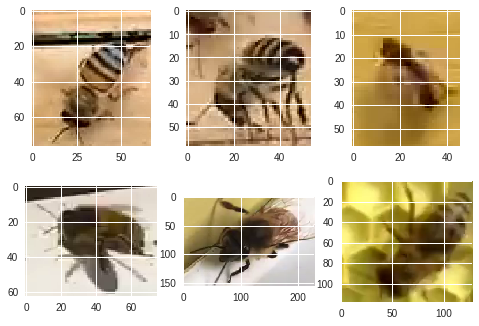

In [38]:
all_images = [os.path.join(base_dir, fname) for fname in os.listdir(base_dir)]
show_bees(all_images[1004:1010])


#Prep the data

The kaggle data is organized as a single csv file for the labels and a single folder containing all the images.  So here I reorganize the images into categorical subfolders, so that I can use ImageDataGenerator and flow_from_directory to feed the files into keras during training, validation and testing.

The original data has the following categories:


1.   hive being robbed
2.   healthy
3.   few varrao, hive beetles 
4.   ant problems
5.   missing queen
6.   Varroa, Small Hive Beetles






I decided to collapse "Varroa" into "few varrao", because it seems a minute, fuzzy distinction, and because I do not know anything about beekeeping. 

Also I eliminated "missing queen", because there are too few instances.



In [0]:
!rm -rf bees/*

df=pd.read_csv('bee_data.csv', 
                index_col=False,  
                parse_dates={'datetime':[1,2]},
                dtype={'subspecies':'category', 'health':'category','caste':'category'})

out_dir = '/content/bees'
shuffle = np.random.randint(df.shape[0], size=(df.shape[0]))
test_size = 500
test_data = shuffle[:test_size]
validate_data = shuffle[test_size:(test_size*2)]
train_data = shuffle[(test_size*2):]

logprint("input sizes:")
logprint("  test = "+str(test_data.shape[0]))
logprint("  valid = "+str(validate_data.shape[0]))
logprint("  train = "+str(train_data.shape[0]))
subfolders = ['test','validate','train']
labels = []
categories = {}

#convert Varroa to few varrao:
def convert(rec):
  if rec['health'] == 'Varroa, Small Hive Beetles':
    return 'few varrao, hive beetles' 
  else:
    return rec['health']
df['health'] = df.apply(lambda x: convert(x), axis=1)

#delete the missing queens:
missing_queens = df[df.health == 'missing queen'].index
logprint("num queens: " + str(missing_queens.shape[0]))
df = df.drop(missing_queens)

#create the subfolders and build the categories dictionary:
count = 0
for health in df.health.unique():
  category = "category"+str(count)
  categories[health] = category
  labels.append(health)
  for subfolder in subfolders:
    dirname = os.path.join(os.path.join(out_dir, subfolder), category)
    if not os.path.exists(dirname):
      os.makedirs(dirname)
  count += 1
  
for key, value in categories.items():
  logprint("categories["+key+"] = "+value)

#initialize a dictionary to store the counts of each sub-subfolder:
counts = {}
for s in range(len(subfolders)):
  counts[subfolders[s]] = {}
  for health, category in categories.items():
    counts[subfolders[s]][category] = 0

count = 0
for filename in os.listdir(base_dir):
  try:
    #for the missing queens the dataframe lookup will throw IndexError:
    health = df[df.file == filename].health.iloc[0]
    category = categories[health]
   
    fromfile = os.path.join(base_dir, filename)
    if count < test_size:
      subfolder = subfolders[0]
    elif count < 2*test_size:
      subfolder = subfolders[1]
    else:
      subfolder = subfolders[2]
    counts[subfolder][category] += 1
    todir = os.path.join(out_dir, os.path.join(subfolder, category))
    tofile = os.path.join(todir, filename)
    shutil.copyfile(fromfile, tofile)
    count += 1
  except IndexError:
    None

totals = {}
for subfolder, cats in counts.items():
  if subfolder not in totals.keys():
    totals[subfolder] = 0
  for category, num in cats.items():
    logprint("counts["+subfolder+"]["+category+"]: "+str(num))
    totals[subfolder] += counts[subfolder][category]
logprint("totals:")
print(totals)

[2019-01-25 17:22:14] input sizes:
[2019-01-25 17:22:14]   test = 500
[2019-01-25 17:22:14]   valid = 500
[2019-01-25 17:22:14]   train = 4172
[2019-01-25 17:22:14] num queens: 29
[2019-01-25 17:22:14] categories[hive being robbed] = category0
[2019-01-25 17:22:14] categories[healthy] = category1
[2019-01-25 17:22:14] categories[few varrao, hive beetles] = category2
[2019-01-25 17:22:14] categories[ant problems] = category3
[2019-01-25 17:22:22] counts[test][category0]: 29
[2019-01-25 17:22:22] counts[test][category1]: 321
[2019-01-25 17:22:22] counts[test][category2]: 112
[2019-01-25 17:22:22] counts[test][category3]: 38
[2019-01-25 17:22:22] counts[validate][category0]: 15
[2019-01-25 17:22:22] counts[validate][category1]: 343
[2019-01-25 17:22:22] counts[validate][category2]: 97
[2019-01-25 17:22:22] counts[validate][category3]: 45
[2019-01-25 17:22:22] counts[train][category0]: 207
[2019-01-25 17:22:22] counts[train][category1]: 2720
[2019-01-25 17:22:22] counts[train][category2]: 

##Create and train the model

In [0]:
from keras.applications import VGG16
import numpy as np

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

58892288/58889256 [==============================] - 3s 0us/step


In [0]:

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')
train_flow = train_datagen.flow_from_directory(
        train_dir,
        target_size=image_size,
        batch_size=20,
        class_mode='categorical')
validation_datagen = ImageDataGenerator(rescale=1./255)
validate_flow = validation_datagen.flow_from_directory(
        validate_dir,
        target_size=image_size,
        batch_size=20,
        class_mode='categorical')

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(4, activation='sigmoid'))

conv_base.trainable = True
set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
        
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_flow,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validate_flow,
      validation_steps=50)


Found 4143 images belonging to 4 classes.
Found 500 images belonging to 4 classes.
Epoch 1/100
100/100 [==============================] - 28s 278ms/step - loss: 1.0241 - acc: 0.6020 - val_loss: 0.6977 - val_acc: 0.6860
Epoch 2/100
100/100 [==============================] - 23s 227ms/step - loss: 0.7189 - acc: 0.6835 - val_loss: 0.5504 - val_acc: 0.7240
Epoch 3/100
100/100 [==============================] - 23s 232ms/step - loss: 0.5866 - acc: 0.7520 - val_loss: 0.3754 - val_acc: 0.8640
Epoch 4/100
100/100 [==============================] - 23s 227ms/step - loss: 0.4578 - acc: 0.8220 - val_loss: 0.2755 - val_acc: 0.9060
Epoch 5/100
100/100 [==============================] - 23s 226ms/step - loss: 0.4301 - acc: 0.8332 - val_loss: 0.2091 - val_acc: 0.9300
Epoch 6/100
100/100 [==============================] - 23s 226ms/step - loss: 0.2966 - acc: 0.8955 - val_loss: 0.2011 - val_acc: 0.9320
Epoch 7/100
100/100 [==============================] - 23s 226ms/step - loss: 0.2958 - acc: 0.8947 - 

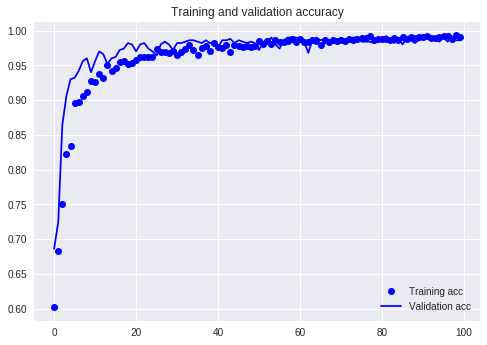

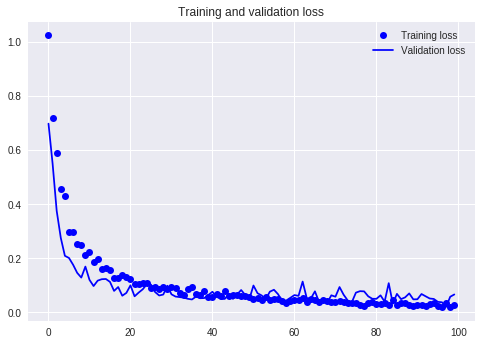

In [0]:

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [0]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_flow = test_datagen.flow_from_directory(
        test_dir,
        target_size=image_size,
        batch_size=20,
        class_mode='categorical')

test_loss, test_acc = model.evaluate_generator(test_flow, steps=40)
print('test acc:', test_acc)

Found 500 images belonging to 4 classes.
test acc: 0.9874999970197678
